# Model Analysis and Interpretation

This notebook performs:
1.  **SHAP Value Analysis**: To understand feature importance and how features influence predictions.
2.  **Outlier & High Residual Analysis**: Using SHAP to investigate instances where the model's predictions deviate significantly from actual values.
3.  **Counterfactual Exploration (Conceptual)**: Manually exploring how changing influential features impacts predictions for specific instances.
4.  **Hyperparameter Quality Visualization**: Using Optuna's visualization tools to analyze hyperparameter tuning results.

--- 
## 1. Setup and Imports

Import necessary libraries and modules from your project.

In [ ]:
import json
import logging
import os
import sys
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import pandas as pd
import plotly
import shap 
import xgboost as xgb
from sklearn.model_selection import KFold

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added '{project_root}' to sys.path for module imports.")
else:
    print(f"'{project_root}' already in sys.path.")

from src.config import load_config
from src.preprocessor import create_data_transformer_pipeline
from src.split_data import get_train_test_data, get_train_test_img

logging.basicConfig(
    level=logging.INFO,
    handlers=[logging.StreamHandler()],
    format="%(asctime)s - %(levelname)s - %(message)s",
)
logging.getLogger("lightgbm").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.4f}".format)
shap.initjs()

/Users/sergiocarcamo/Dev/thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Added '/Users/sergiocarcamo/Dev/thesis' to sys.path for module imports.


--- 
## 2. Configuration and MLflow Setup

Load configurations and define MLflow experiment details.

**ACTION REQUIRED**:
- `SELECTED_FEATURES_FILENAME_FOR_ANALYSIS`: Set this to the name of the feature set JSON file (without .json extension) for the model you want to analyze (e.g., `"rfecv_all_nfeat_44_pca_scaled_count"`).
- `MODEL_NAME_FOR_ANALYSIS`: Set this to the model type you want to analyze (e.g., `"LightGBM"`, `"XGBoost"`).
- `MLFLOW_RUN_ID_FOR_ANALYSIS` (Optional): If you know the specific MLflow Run ID for the "BEST" model run, set it here. Otherwise, the notebook will try to find the best run based on `MODEL_NAME_FOR_ANALYSIS` and `SELECTED_FEATURES_FILENAME_FOR_ANALYSIS`.

In [ ]:
config_values = load_config()

TARGET_VARIABLE = config_values.get("TARGET_VARIABLE", "price")
RANDOM_STATE = config_values.get("RANDOM_STATE", 42)
SELECTED_FEATURES_DIR = config_values.get("SELECTED_FEATURES_DIR", "feature_sets")
MLFLOW_TRACKING_URI = mlflow.get_tracking_uri()

SELECTED_FEATURES_FILENAME_FOR_ANALYSIS = "rfecv_base_nfeat_117_nonpca_count_loc" 
MODEL_NAME_FOR_ANALYSIS = "LightGBM"
MLFLOW_RUN_ID_FOR_ANALYSIS = None

selected_features_path_for_analysis = os.path.join(
    "..", SELECTED_FEATURES_DIR, f"{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}.json"
)

feature_set_identifier = SELECTED_FEATURES_FILENAME_FOR_ANALYSIS.replace(".json", "")
MLFLOW_EXPERIMENT_NAME = (
    f"RE price predictor - {TARGET_VARIABLE} - {feature_set_identifier}"
)

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

logging.info(f"Using MLflow Tracking URI: {MLFLOW_TRACKING_URI}")
logging.info(f"Using MLflow Experiment: '{MLFLOW_EXPERIMENT_NAME}'")
logging.info(f"Analyzing model: {MODEL_NAME_FOR_ANALYSIS} with feature set: {SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}")

2025/06/12 01:43:13 INFO mlflow.tracking.fluent: Experiment with name 'RE price predictor - price - rfecv_base_nfeat_117_nonpca_count_loc' does not exist. Creating a new experiment.
2025-06-12 01:43:13,655 - INFO - Using MLflow Tracking URI: file:///Users/sergiocarcamo/Dev/thesis/notebooks/mlruns
2025-06-12 01:43:13,656 - INFO - Using MLflow Experiment: 'RE price predictor - price - rfecv_base_nfeat_117_nonpca_count_loc'
2025-06-12 01:43:13,656 - INFO - Analyzing model: LightGBM with feature set: rfecv_base_nfeat_117_nonpca_count_loc


In [3]:

f"{MODEL_NAME_FOR_ANALYSIS}_{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}_BEST"

'LightGBM_rfecv_base_nfeat_117_nonpca_count_loc_BEST'

--- 
## 3. Load Data and Feature Selection Metadata

Load the test data and metadata from the selected feature set.

In [4]:
try:
    with open(selected_features_path_for_analysis, "r") as f:
        feature_data = json.load(f)
        selected_feature_names_from_file = feature_data.get("selected_features", [])
        feature_selection_metadata = feature_data.get("metadata", {})
    if not selected_feature_names_from_file:
        raise ValueError("No 'selected_features' found in JSON.")
    if not feature_selection_metadata:
        logging.warning("No 'metadata' found in feature selection JSON. Using global defaults.")
    else:
        logging.info(f"Loaded feature selection metadata: {feature_selection_metadata}")
except Exception as e:
    logging.error(f"Error loading feature selection file {selected_features_path_for_analysis}: {e}")
    raise

APPLY_SCALE_TRANSFORM = feature_selection_metadata.get(
    "apply_scale_transform", config_values.get("APPLY_SCALE_TRANSFORM")
)
APPLY_PCA_IMG_TRANSFORM = feature_selection_metadata.get(
    "apply_pca_img_transform", config_values.get("APPLY_PCA_IMG_TRANSFORM")
)
N_PCA_COMPONENTS = feature_selection_metadata.get(
    "n_pca_components", config_values.get("N_PCA_COMPONENTS")
)

INCLUDE_LOCATION_FEATURES = feature_selection_metadata.get(
    "include_location_features", config_values.get("INCLUDE_LOCATION_FEATURES")
)

current_random_state = feature_selection_metadata.get("random_state", RANDOM_STATE)
if current_random_state != RANDOM_STATE:
    logging.info(f"RANDOM_STATE overridden by metadata: {current_random_state}")
    RANDOM_STATE = current_random_state
    np.random.seed(RANDOM_STATE)

logging.info(f"Effective APPLY_SCALE_TRANSFORM: {APPLY_SCALE_TRANSFORM}")
logging.info(f"Effective APPLY_PCA_IMG_TRANSFORM: {APPLY_PCA_IMG_TRANSFORM}")
logging.info(f"Effective N_PCA_COMPONENTS: {N_PCA_COMPONENTS}")

X_train_full_raw, X_test_full_raw, Y_train_raw, Y_test_raw = get_train_test_data(include_count=feature_selection_metadata.get("include_count", True))
img_train_raw, img_test_raw = get_train_test_img()

X_test_sample = X_test_full_raw

Y_train_log_transformed = np.log(Y_train_raw[TARGET_VARIABLE])
Y_test_log_transformed = np.log(Y_test_raw[TARGET_VARIABLE])

logging.info(f"X_test_sample shape: {X_test_sample.shape}")
logging.info(f"Y_test_log_transformed shape: {Y_test_log_transformed.shape}")

district_col_name = "district"
outlier_col_name = "outlier"

original_img_cols = img_train_raw.columns.tolist()
original_numeric_cols = X_train_full_raw.select_dtypes(include=np.number).columns.tolist()
original_numeric_cols = [
    col for col in original_numeric_cols
    if col != TARGET_VARIABLE and col != outlier_col_name and col not in original_img_cols
]
original_categorical_cols = X_train_full_raw.select_dtypes(include=["object", "category"]).columns.tolist()
if not INCLUDE_LOCATION_FEATURES:
    original_categorical_cols = [col for col in original_categorical_cols if col != district_col_name]

2025-06-12 01:43:13,740 - INFO - Loaded feature selection metadata: {'method': 'rfecv', 'feature_subset_used': 'base', 'n_features_selected': 117, 'apply_pca_img_transform': False, 'n_pca_components': None, 'apply_scale_transform': False, 'include_count': True, 'include_location_features': True, 'n_estimators': 200, 'random_state': 42, 'rfe_step_size': 10}
2025-06-12 01:43:13,747 - INFO - Effective APPLY_SCALE_TRANSFORM: False
2025-06-12 01:43:13,748 - INFO - Effective APPLY_PCA_IMG_TRANSFORM: False
2025-06-12 01:43:13,748 - INFO - Effective N_PCA_COMPONENTS: None
2025-06-12 01:43:25,835 - INFO - X_test_sample shape: (9330, 697)
2025-06-12 01:43:25,847 - INFO - Y_test_log_transformed shape: (9330,)


In [ ]:
mlflow.set_tracking_uri("file:///Users/sergiocarcamo/Dev/thesis/mlruns")

version = 'v1'
target_run_name = f"{MODEL_NAME_FOR_ANALYSIS}_{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}_mape_{version}_BEST"

mlflow.search_runs(
    search_all_experiments=True,
    filter_string=f"tags.\"mlflow.runName\" = '{target_run_name}' AND tags.run_type = 'best_run'",
    order_by=["metrics.cv_mape ASC"],     

)
# LightGBM_rfecv_all_nfeat_44_pca_scaled_count_BEST

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_final_mape,metrics.test_final_r2,metrics.test_final_rmse,metrics.train_final_rmse,...,tags.experiment_version,tags.mlflow.user,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.run_type,tags.mlflow.source.git.commit,tags.mlflow.parentRunId,tags.mlflow.source.name,tags.mlflow.runName,tags.feature_set
0,3c63489e6e1148e3b61b428076711ce7,892381738994761758,FINISHED,file:///Users/sergiocarcamo/Dev/thesis/mlruns/...,2025-06-10 15:07:42.705000+00:00,2025-06-10 15:07:56.429000+00:00,0.0106,0.9472,88525.6559,16679.2985,...,v1,sergiocarcamo,"[{""run_id"": ""3c63489e6e1148e3b61b428076711ce7""...",LOCAL,best_run,7fd50e8d4ddc17c17a7919c57bce0b5461fd8350,106e357f8e9048aea9dbbdb3ca843fec,main.py,LightGBM_rfecv_base_nfeat_117_nonpca_count_loc...,rfecv_base_nfeat_117_nonpca_count_loc


--- 
## 4. Load Trained Model and Preprocessor from MLflow

We need to find the "BEST" run for the specified model and feature set, then load the model and reconstruct the preprocessor.

In [ ]:
from xgboost import XGBRegressor

if 'MLFLOW_RUN_ID_FOR_ANALYSIS' not in locals() or MLFLOW_RUN_ID_FOR_ANALYSIS is None:
    try:
        experiment = mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
        if experiment is None:
            raise ValueError(f"Experiment '{MLFLOW_EXPERIMENT_NAME}' not found.")
        
        target_run_name = f"{MODEL_NAME_FOR_ANALYSIS}_{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}_mape_{version}_BEST"
        
        print(MLFLOW_EXPERIMENT_NAME, experiment.experiment_id, target_run_name)

        best_runs_df = mlflow.search_runs(
            search_all_experiments=True, 
            filter_string=f"tags.mlflow.runName = '{target_run_name}' AND tags.run_type = 'best_run'",
            order_by=["metrics.test_final_mape ASC"],
            max_results=1
        )

        if best_runs_df.empty:
            raise ValueError(f"No 'best_run' found for {MODEL_NAME_FOR_ANALYSIS} with feature set {SELECTED_FEATURES_FILENAME_FOR_ANALYSIS} and name {target_run_name}.")
        
        MLFLOW_RUN_ID_FOR_ANALYSIS = best_runs_df.iloc[0]["run_id"]
        logging.info(f"Found best run ID: {MLFLOW_RUN_ID_FOR_ANALYSIS} with name '{target_run_name}'")
    except Exception as e:
        logging.error(f"Could not automatically find the best run: {e}")
        logging.error("Please set MLFLOW_RUN_ID_FOR_ANALYSIS manually.")
        raise

# Load the model
# The model artifact path in train.py is like f"{MODEL_NAME_FOR_ANALYSIS}_model" or f"{MODEL_NAME_FOR_ANALYSIS}_pipeline"
model_artifact_path_sklearn = f"runs:/{MLFLOW_RUN_ID_FOR_ANALYSIS}/{MODEL_NAME_FOR_ANALYSIS}_pipeline"
model_artifact_path_native = f"runs:/{MLFLOW_RUN_ID_FOR_ANALYSIS}/{MODEL_NAME_FOR_ANALYSIS}_model"

loaded_model = None
actual_model = None 

try:
    if MODEL_NAME_FOR_ANALYSIS in ["LightGBM", "XGBoost", "XGBoostQuantile"]:
        if MODEL_NAME_FOR_ANALYSIS == "LightGBM":
            try:
                logging.info(f"Trying to load LightGBM native model from {model_artifact_path_native}")
                actual_model = mlflow.lightgbm.load_model(model_artifact_path_native)
                logging.info(f"Successfully loaded native LightGBM model: {type(actual_model)}")
            except Exception as e:
                logging.warning(f"Failed to load native LightGBM model directly: {e}")
                logging.info(f"Falling back to pyfunc.load_model and attempting extraction...")
                loaded_model = mlflow.pyfunc.load_model(model_artifact_path_native)
                actual_model = loaded_model # Keep as PyFunc for now

        elif MODEL_NAME_FOR_ANALYSIS in ["XGBoost", "XGBoostQuantile"]:
            try:
                logging.info(f"Trying to load XGBoost native model from {model_artifact_path_native}")
                actual_model = mlflow.xgboost.load_model(model_artifact_path_native)
                logging.info(f"Successfully loaded native XGBoost model: {type(actual_model)}")
            except Exception as e:
                logging.warning(f"Failed to load native XGBoost model directly: {e}")
                logging.info(f"Falling back to pyfunc.load_model and attempting extraction...")
                loaded_model = mlflow.pyfunc.load_model(model_artifact_path_native)
                actual_model = loaded_model 

        xgboost_model_types = (xgb.Booster, XGBRegressor)
        direct_tree_model_types = (lgb.Booster, lgb.LGBMRegressor) + xgboost_model_types

        # try pyfunc
        if actual_model is None or not isinstance(actual_model, direct_tree_model_types):
            logging.warning(f"Native model for {MODEL_NAME_FOR_ANALYSIS} not directly loaded. SHAP might be slower or require KernelExplainer.")
            if loaded_model is None:
                 loaded_model = mlflow.pyfunc.load_model(model_artifact_path_native)
            actual_model = loaded_model # Use the PyFunc model for SHAP

        # fallback
        if actual_model is None or not isinstance(actual_model, (lgb.Booster,) + xgboost_model_types):
             try:
                 logging.info(f"Attempting to load {MODEL_NAME_FOR_ANALYSIS} as sklearn model/pipeline from {model_artifact_path_sklearn}")
                 sklearn_pipeline_model = mlflow.sklearn.load_model(model_artifact_path_sklearn)
                 if hasattr(sklearn_pipeline_model, 'named_steps') and 'model' in sklearn_pipeline_model.named_steps:
                     actual_model = sklearn_pipeline_model.named_steps['model']
                     logging.info(f"Successfully loaded model step from sklearn pipeline: {type(actual_model)}")
                 else:
                     actual_model = sklearn_pipeline_model # It might be the model itself
                     logging.info(f"Successfully loaded sklearn model/pipeline: {type(actual_model)}")
             except Exception as e_sklearn:
                 logging.error(f"Failed to load as sklearn model/pipeline from {model_artifact_path_sklearn}: {e_sklearn}")
                 if actual_model is None: # Only raise if no model was loaded at all
                     raise ValueError(f"No model could be loaded for {MODEL_NAME_FOR_ANALYSIS}")

    else: # For RandomForest
        logging.info(f"Loading {MODEL_NAME_FOR_ANALYSIS} as sklearn pipeline from {model_artifact_path_sklearn}")
        sklearn_pipeline_model = mlflow.sklearn.load_model(model_artifact_path_sklearn)
        if hasattr(sklearn_pipeline_model, 'named_steps') and 'model' in sklearn_pipeline_model.named_steps:
            actual_model = sklearn_pipeline_model.named_steps['model']
            logging.info(f"Successfully extracted model from sklearn pipeline: {type(actual_model)}")
        else:
            actual_model = sklearn_pipeline_model
            logging.info(f"Successfully loaded sklearn model directly: {type(actual_model)}")

    if actual_model is None:
        raise ValueError("Model was not successfully loaded into 'actual_model'.")

    logging.info(f"Successfully loaded model: {MODEL_NAME_FOR_ANALYSIS} (type: {type(actual_model)}) from run ID: {MLFLOW_RUN_ID_FOR_ANALYSIS}")

except Exception as e:
    logging.error(f"Error loading model from MLflow run {MLFLOW_RUN_ID_FOR_ANALYSIS}: {e}")
    logging.error(f"Tried paths: {model_artifact_path_native} (native) and {model_artifact_path_sklearn} (sklearn pipeline)")
    raise

2025-06-12 01:43:26,413 - INFO - Found best run ID: 3c63489e6e1148e3b61b428076711ce7 with name 'LightGBM_rfecv_base_nfeat_117_nonpca_count_loc_mape_v1_BEST'
2025-06-12 01:43:26,419 - INFO - Trying to load LightGBM native model from runs:/3c63489e6e1148e3b61b428076711ce7/LightGBM_model


RE price predictor - price - rfecv_base_nfeat_117_nonpca_count_loc 283163517237772995 LightGBM_rfecv_base_nfeat_117_nonpca_count_loc_mape_v1_BEST


2025-06-12 01:43:26,791 - INFO - Successfully loaded native LightGBM model: <class 'lightgbm.sklearn.LGBMRegressor'>
2025-06-12 01:43:26,792 - INFO - Attempting to load LightGBM as sklearn model/pipeline from runs:/3c63489e6e1148e3b61b428076711ce7/LightGBM_pipeline
2025-06-12 01:43:26,799 - ERROR - Failed to load as sklearn model/pipeline from runs:/3c63489e6e1148e3b61b428076711ce7/LightGBM_pipeline: No such file or directory: '/Users/sergiocarcamo/Dev/thesis/mlruns/892381738994761758/3c63489e6e1148e3b61b428076711ce7/artifacts/LightGBM_pipeline'
2025-06-12 01:43:26,799 - INFO - Successfully loaded model: LightGBM (type: <class 'lightgbm.sklearn.LGBMRegressor'>) from run ID: 3c63489e6e1148e3b61b428076711ce7


In [ ]:

try:
    feature_artifact_path = f"runs:/{MLFLOW_RUN_ID_FOR_ANALYSIS}/feature_info/final_selected_features_list.txt"
    

    import tempfile
    with tempfile.TemporaryDirectory() as temp_dir:
        downloaded_path = mlflow.artifacts.download_artifacts(feature_artifact_path, dst_path=temp_dir)
        
        with open(downloaded_path, 'r') as f:
            actual_training_features = [line.strip() for line in f.readlines() if line.strip()]
    
    logging.info(f"Loaded {len(actual_training_features)} actual training features from MLflow")
    logging.info(f"First 10 actual training features: {actual_training_features[:10]}")
    
    selected_feature_names_from_file = actual_training_features
    
except Exception as e:
    logging.warning(f"Could not load actual training features from MLflow: {e}")
    logging.warning("Falling back to feature selection JSON file features")



2025-06-12 01:43:26,845 - INFO - Loaded 117 actual training features from MLflow
2025-06-12 01:43:26,846 - INFO - First 10 actual training features: ['latitude', 'longitude', 'is_private_owner', 'area_m2', 'floor_number', 'building_floors_num', 'has_lift', 'has_internet', 'has_furniture', 'has_air_conditioning']


<Axes: xlabel='importance', ylabel='feature'>

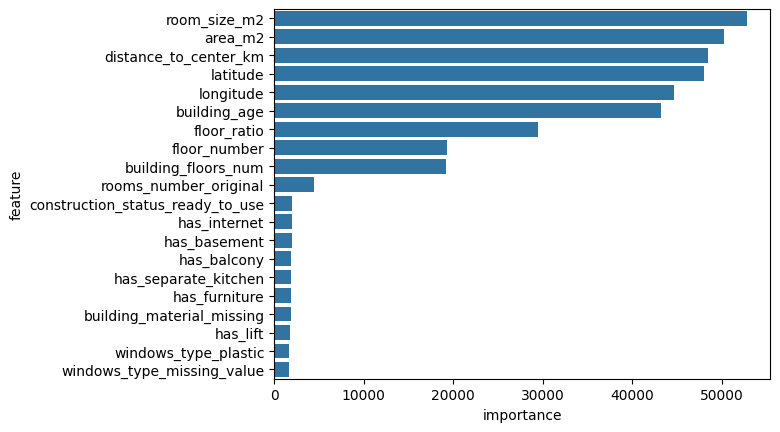

In [8]:
import seaborn as sns


if hasattr(actual_model, 'feature_importances_'):
    feature_importances = actual_model.feature_importances_
    feature_names = actual_model.feature_name_ if hasattr(actual_model, 'feature_name_') else None
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

sns.barplot(
    data=feature_importance_df.head(20),
    x='importance',
    y='feature'
)

In [9]:

data_transformer = create_data_transformer_pipeline(
    numeric_cols=original_numeric_cols,
    categorical_cols=original_categorical_cols,
    img_feature_cols=original_img_cols,
    district_group_col=district_col_name,
    outlier_indicator_col=outlier_col_name,
    apply_scaling_and_transform=APPLY_SCALE_TRANSFORM,
    apply_pca=APPLY_PCA_IMG_TRANSFORM,
    n_pca_components=N_PCA_COMPONENTS
)

logging.info("Fitting data_transformer on X_train_full_raw...")
data_transformer.fit(X_train_full_raw.copy(), Y_train_log_transformed)
logging.info("Data_transformer fitted.")


X_test_processed_np = data_transformer.transform(X_test_sample.copy())


try:
    processed_feature_names = data_transformer.get_feature_names_out()
    X_test_processed_df = pd.DataFrame(
        X_test_processed_np,
        columns=processed_feature_names,
        index=X_test_sample.index
    )
    logging.info(f"X_test_processed_df shape: {X_test_processed_df.shape}")
except Exception as e:
    logging.error(f"Error getting feature names from transformer: {e}. SHAP plots might lack feature names.")
    X_test_processed_df = pd.DataFrame(X_test_processed_np, index=X_test_sample.index)


final_selected_feature_names_for_model = [
    name for name in selected_feature_names_from_file if name in X_test_processed_df.columns
]

if len(final_selected_feature_names_for_model) != len(selected_feature_names_from_file):
    missing_in_test_processed = set(selected_feature_names_from_file) - set(final_selected_feature_names_for_model)
    logging.warning(f"Some selected features from file were not found in the processed test data columns. Missing: {missing_in_test_processed}")
    logging.warning(f"Using {len(final_selected_feature_names_for_model)} available features.")

    raise ValueError("The number of selected features from file does not match the number of features in the processed test data.")



if not final_selected_feature_names_for_model:
    raise ValueError("No selected features are present in the processed test data. Check feature names and preprocessing consistency.")

X_test_selected_final = X_test_processed_df[final_selected_feature_names_for_model]
logging.info(f"X_test_selected_final shape for SHAP: {X_test_selected_final.shape}")

2025-06-12 01:43:27,442 - INFO - Fitting data_transformer on X_train_full_raw...
2025-06-12 01:43:34,011 - INFO - Data_transformer fitted.
2025-06-12 01:43:34,745 - INFO - X_test_processed_df shape: (9330, 775)
2025-06-12 01:43:34,754 - INFO - X_test_selected_final shape for SHAP: (9330, 117)


--- 
## 5. SHAP Analysis

Calculate and visualize SHAP values to understand feature contributions.

In [ ]:
#  LightGBM, XGBoost, RandomForest

import logging


logging.getLogger('shap').setLevel(logging.WARNING)

sklearn_pipeline_model = None 


is_native_tree_model = isinstance(actual_model, (lgb.Booster, lgb.LGBMRegressor,
                                                 xgb.Booster, xgb.XGBRegressor,))


def wrapped_predict_fn(data_input, model_to_predict, feature_columns):
    """
    Wraps the model's predict function to ensure input is a pandas DataFrame
    with the correct column names, as expected by MLflow PyFuncModels.
    """
    if isinstance(data_input, np.ndarray):

        data_input_df = pd.DataFrame(data_input, columns=feature_columns)
    elif isinstance(data_input, pd.DataFrame):
        data_input_df = data_input[feature_columns]
    else:
        raise TypeError(f"Unexpected input type for wrapped_predict_fn: {type(data_input)}")

    return model_to_predict.predict(data_input_df)


if is_native_tree_model:
    try:
        if hasattr(actual_model, 'predict_proba') or hasattr(actual_model, 'predict'):
             explainer = shap.TreeExplainer(actual_model, data=X_test_selected_final) 
             logging.info(f"Using shap.TreeExplainer for native {MODEL_NAME_FOR_ANALYSIS} model.")
        else:
            raise TypeError(f"actual_model is of type {type(actual_model)}, not a base estimator suitable for TreeExplainer. It might be a pipeline.")
    except Exception as tree_explainer_ex:
        logging.warning(f"Could not initialize TreeExplainer directly for {type(actual_model)} (Error: {tree_explainer_ex}). Falling back to KernelExplainer, which will be slower.")
        
        model_object_for_predict = None
        if sklearn_pipeline_model is not None:
            model_object_for_predict = sklearn_pipeline_model
        else:
            model_object_for_predict = actual_model

        if model_object_for_predict is None or not hasattr(model_object_for_predict, 'predict'):
            logging.error("Cannot determine suitable model object or predict function for KernelExplainer.")
            raise ValueError("No suitable predict function found for SHAP KernelExplainer.")


        predict_fn_for_shap = lambda x: wrapped_predict_fn(x, model_object_for_predict, final_selected_feature_names_for_model)

        X_train_processed_shap_bg_np = data_transformer.transform(X_train_full_raw.sample(min(100, len(X_train_full_raw)), random_state=RANDOM_STATE).copy())
        X_train_processed_shap_bg_df = pd.DataFrame(X_train_processed_shap_bg_np, columns=processed_feature_names)[final_selected_feature_names_for_model]

        explainer = shap.KernelExplainer(predict_fn_for_shap, X_train_processed_shap_bg_df)
        logging.info(f"Using shap.KernelExplainer for {MODEL_NAME_FOR_ANALYSIS}.")
else: 
    logging.info(f"Attempting KernelExplainer for {MODEL_NAME_FOR_ANALYSIS} as it's not a direct native tree model or was loaded as PyFunc.")

    X_train_sample_raw = X_train_full_raw.sample(min(100, len(X_train_full_raw)), random_state=RANDOM_STATE).copy()
    X_train_bg_processed_np = data_transformer.transform(X_train_sample_raw)
    X_train_bg_processed_df = pd.DataFrame(X_train_bg_processed_np, columns=processed_feature_names, index=X_train_sample_raw.index)
    X_train_bg_selected_final = X_train_bg_processed_df[final_selected_feature_names_for_model]

    model_object_for_predict = None
    if sklearn_pipeline_model is not None:
        model_object_for_predict = sklearn_pipeline_model
    else:
        model_object_for_predict = actual_model

    if model_object_for_predict is None or not hasattr(model_object_for_predict, 'predict'):
        logging.error("Cannot determine suitable model object or predict function for KernelExplainer.")
        raise ValueError("No suitable predict function found for SHAP KernelExplainer.")

    # Create the actual predict function for SHAP KernelExplainer
    predict_fn_for_shap = lambda x: wrapped_predict_fn(x, model_object_for_predict, final_selected_feature_names_for_model)

    explainer = shap.KernelExplainer(predict_fn_for_shap, X_train_bg_selected_final)
    logging.info(f"Using shap.KernelExplainer for {MODEL_NAME_FOR_ANALYSIS}.")


# Calculate SHAP values
import os
import pickle

os.makedirs("shap_values", exist_ok=True)

shap_values_file_path = f"shap_values/shap_values_{target_run_name}.pkl"

print(f"SHAP values file path: {shap_values_file_path}")

if not os.path.exists(shap_values_file_path):
    shap_values_test = explainer.shap_values(X_test_selected_final)
    with open(shap_values_file_path, "wb") as f:
        pickle.dump(shap_values_test, f)
    logging.info("SHAP values calculated.")
else:
    with open(shap_values_file_path, "rb") as f:
        shap_values_test = pickle.load(f)


2025-06-12 01:43:55,871 - INFO - Using shap.TreeExplainer for native LightGBM model.


SHAP values file path: shap_values/shap_values_LightGBM_rfecv_base_nfeat_117_nonpca_count_loc_mape_v1_BEST.pkl


In [11]:
print(f"SHAP values file path: {shap_values_file_path}")

SHAP values file path: shap_values/shap_values_LightGBM_rfecv_base_nfeat_117_nonpca_count_loc_mape_v1_BEST.pkl


### Global Feature Importance (Bar Plot)

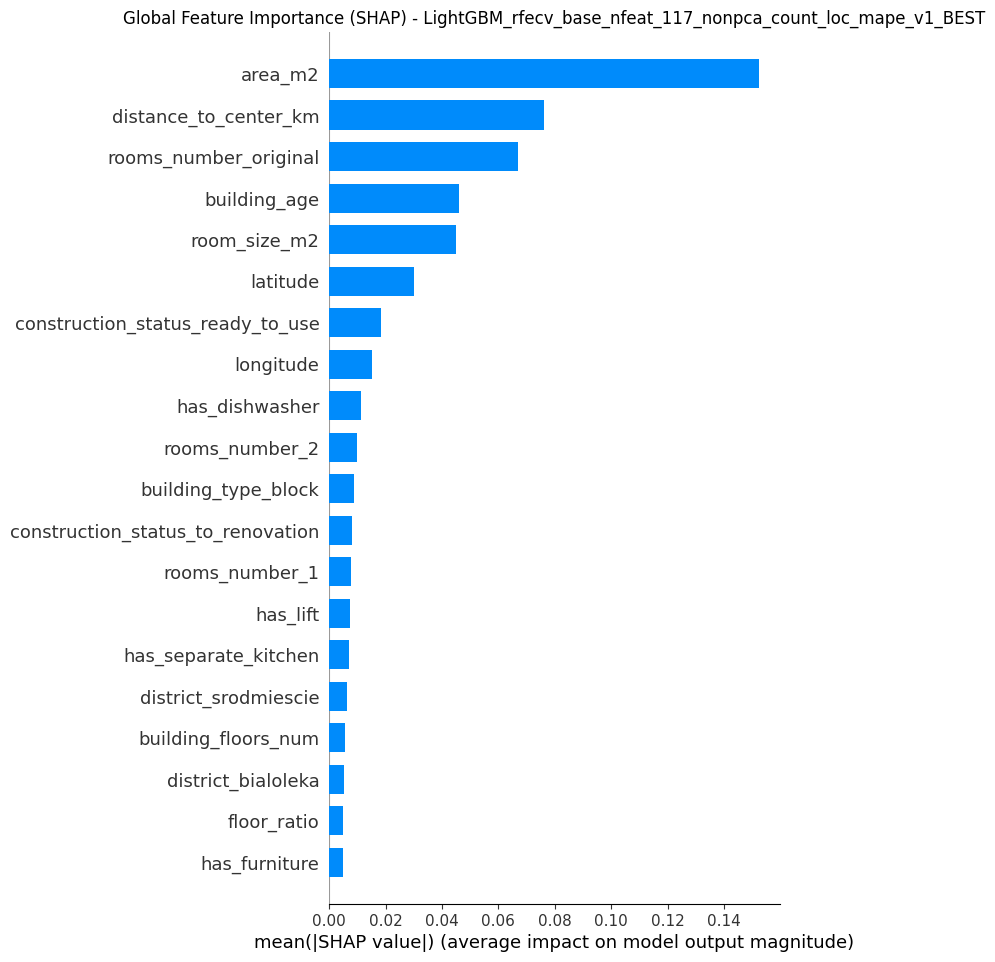

In [12]:
shap.summary_plot(shap_values_test, X_test_selected_final, plot_type="bar", show=False)
plt.title(f"Global Feature Importance (SHAP) - {target_run_name}")

plt.show()

In [13]:
shap_values_test.shape, X_test_selected_final.shape

((9330, 117), (9330, 117))

### SHAP Summary Plot (Beeswarm)
Shows feature importance and impact. Each dot is a data point. Color indicates feature value (red=high, blue=low). X-axis is SHAP value.

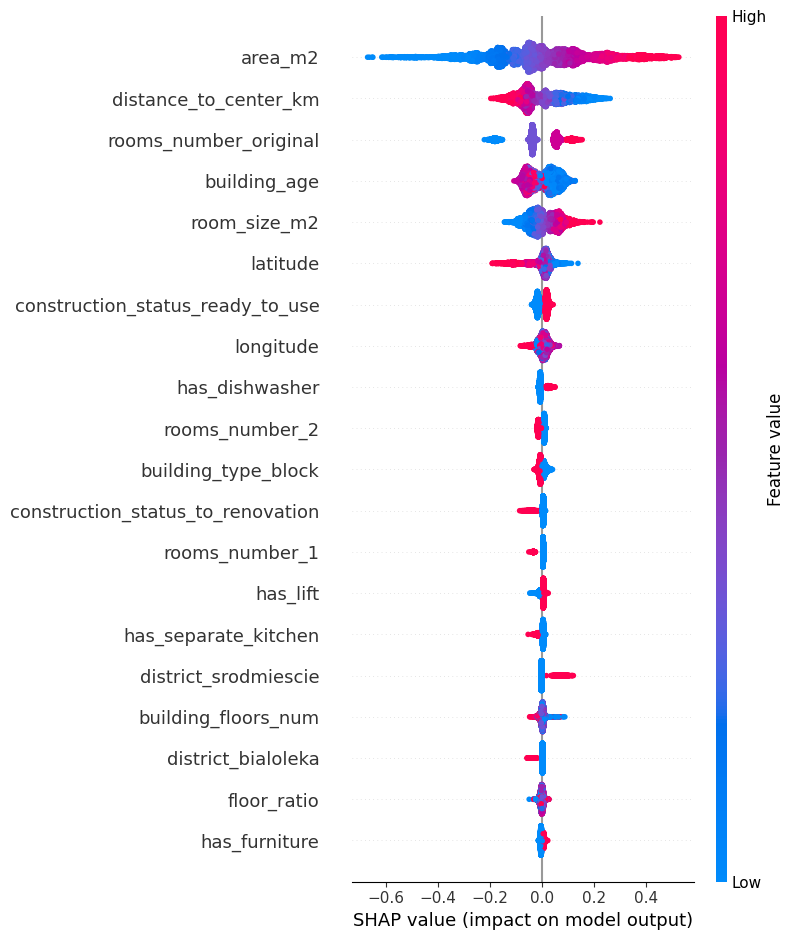

In [14]:
shap.summary_plot(shap_values_test, X_test_selected_final, show=False)
# plt.title(f"SHAP Summary Plot - {MODEL_NAME_FOR_ANALYSIS}") # Title might not be directly settable on this plot
plt.show()

### SHAP Dependence Plots
Shows how a single feature's value affects its SHAP value (and thus the prediction), optionally colored by an interaction feature.
**ACTION REQUIRED**: Update `features_to_plot` with relevant feature names from `final_selected_feature_names_for_model`.

2025-06-12 01:43:59,309 - INFO - Generating dependence plots for features: ['area_m2', 'distance_to_center_km', 'rooms_number_original', 'building_age', 'room_size_m2']


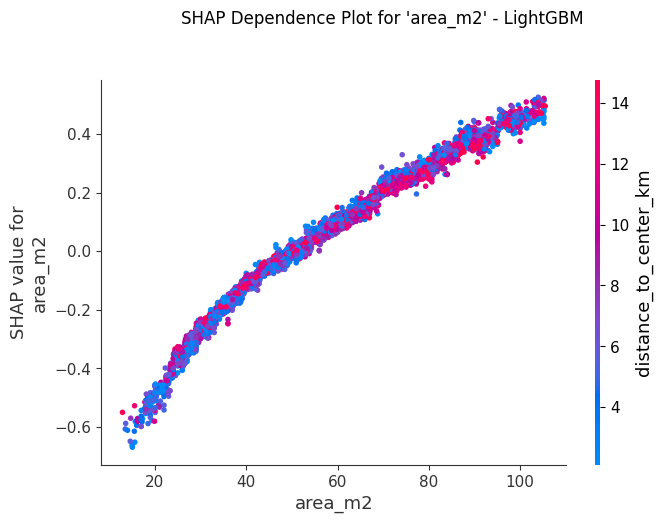

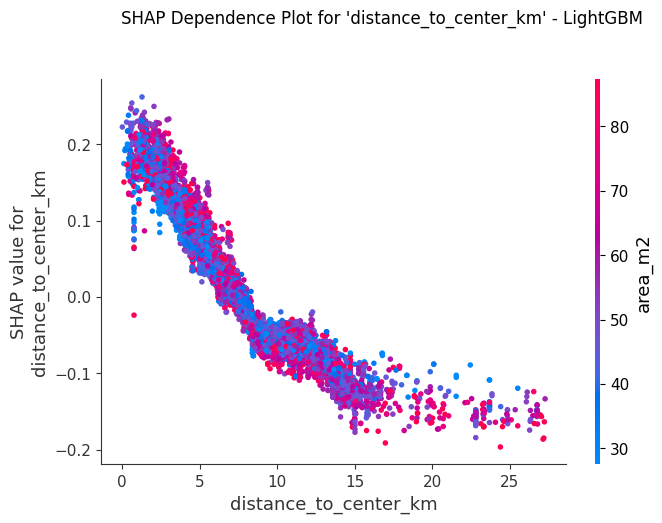

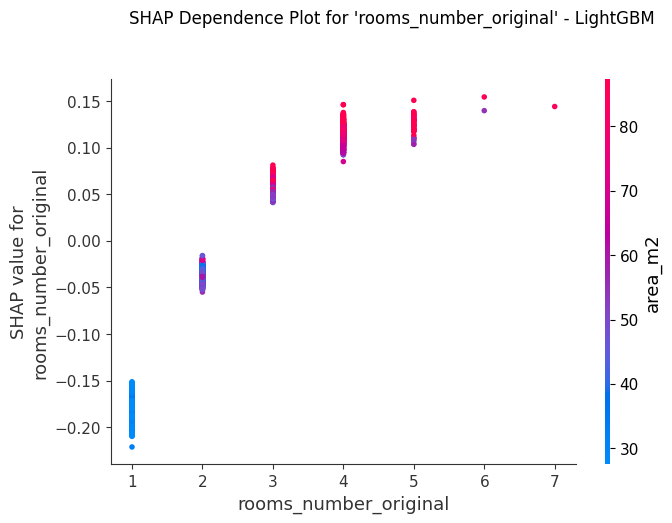

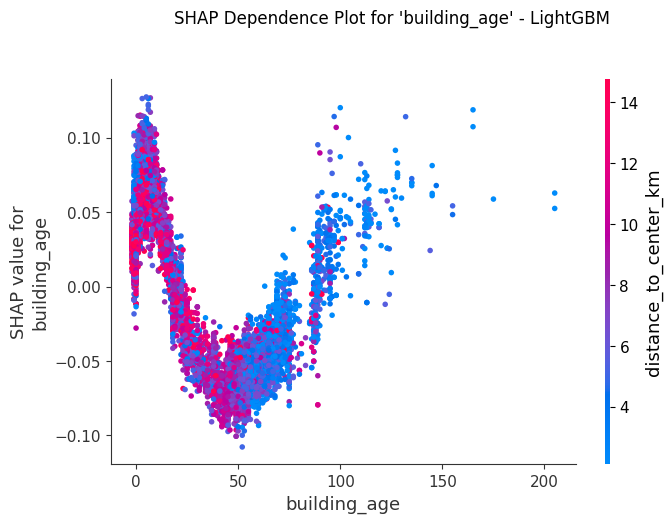

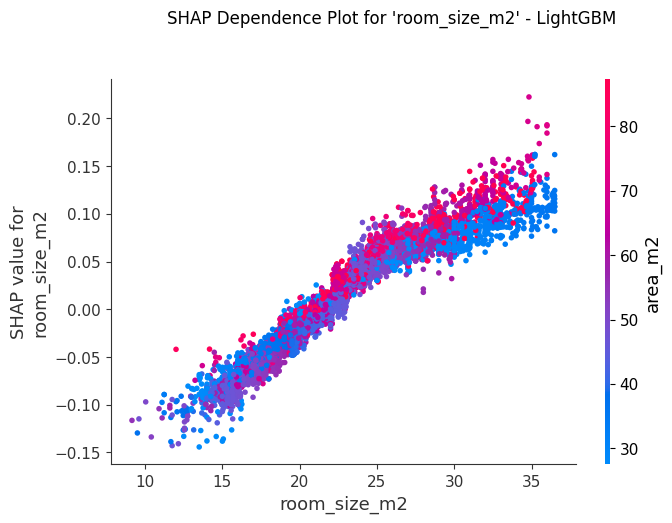

In [ ]:
if len(final_selected_feature_names_for_model) > 0:
    num_dependence_plots = min(5, len(final_selected_feature_names_for_model))
    
    mean_abs_shap = np.abs(shap_values_test).mean(0)
    if isinstance(X_test_selected_final, pd.DataFrame):
        feature_names_for_plot = X_test_selected_final.columns
    else: 
        feature_names_for_plot = [f"feature_{i}" for i in range(X_test_selected_final.shape[1])]

    top_feature_indices = np.argsort(mean_abs_shap)[::-1][:num_dependence_plots]
    features_to_plot = [feature_names_for_plot[i] for i in top_feature_indices]
    
    logging.info(f"Generating dependence plots for features: {features_to_plot}")

    for feature_name in features_to_plot:
        try:
            shap.dependence_plot(
                feature_name,
                shap_values_test,
                X_test_selected_final,
                interaction_index="auto", # Automatically picks an interaction feature
                show=False
            )
            plt.suptitle(f"SHAP Dependence Plot for '{feature_name}' - {MODEL_NAME_FOR_ANALYSIS}", y=1.02)
            plt.show()
        except Exception as e:
            logging.warning(f"Could not generate dependence plot for {feature_name}: {e}")
else:
    logging.warning("No features available to generate dependence plots.")

--- 
## 6. Outlier & High Residual Analysis with SHAP

Investigate instances where the model's predictions are significantly off.

In [ ]:
if 'sklearn_pipeline_model' in locals() and (MODEL_NAME_FOR_ANALYSIS not in ["LightGBM", "XGBoost", "XGBoostQuantile"] or not hasattr(actual_model, 'predict')): # If it's a pipeline
    Y_predict_log_test = sklearn_pipeline_model.predict(X_test_selected_final)
    logging.info("Predictions made using the sklearn_pipeline_model for residuals.")
else: 
    Y_predict_log_test = actual_model.predict(X_test_selected_final)
    logging.info("Predictions made using the actual_model (base estimator) for residuals.")


Y_predict_orig_test = np.exp(Y_predict_log_test)
Y_true_orig_test = np.exp(Y_test_log_transformed.loc[X_test_selected_final.index]) 

# Calculate residuals
residuals_df = pd.DataFrame({
    'true_price': Y_true_orig_test,
    'predicted_price': Y_predict_orig_test,
    'residual': Y_true_orig_test - Y_predict_orig_test,
    'abs_residual': np.abs(Y_true_orig_test - Y_predict_orig_test)
}, index=X_test_selected_final.index)

residuals_df = residuals_df.sort_values(by='abs_residual', ascending=False)

logging.info("Top 5 instances with highest absolute residuals:")
print(residuals_df.head())

2025-06-12 01:44:09,954 - INFO - Predictions made using the actual_model (base estimator) for residuals.
2025-06-12 01:44:09,960 - INFO - Top 5 instances with highest absolute residuals:


           true_price  predicted_price     residual  abs_residual
id                                                               
65979253 2300000.0000     1190272.6663 1109727.3337  1109727.3337
65903147 2000000.0000      967161.8918 1032838.1082  1032838.1082
64921655 2650000.0000     1759359.8861  890640.1139   890640.1139
65906372 2000000.0000     1180180.0161  819819.9839   819819.9839
65659145 2370000.0000     1597326.5618  772673.4382   772673.4382


In [17]:
import pandas as pd
import os

selected_features = [
    'district', 'neighborhood', 'area_m2', 'building_age', 'pano_parks_area', 'distance_to_center_km',
     'pano_transport_buses', 'count_cafe_1km',
    'has_dishwasher', 'building_type', 'park_areas_3000_m2', 'dist_museum',
    'latitude', 'building_floors_num', 'dist_subway', 'pano_bushes_planted',
    'room_size_m2', 'is_private_owner', 'rooms_number', 'floor_number', 'heating',
    'building_material', 'has_internet', 'has_furniture', 'has_lift', 'advertiser_type', 'construction_status'
]



raw_df = pd.read_csv(os.path.join("..", "data", "real_estate_thesis_processed.csv"), index_col=0, usecols=["id"]+selected_features)
if 'id' in raw_df.columns:
    raw_df.set_index('id', inplace=True)

flats_analysis_df = residuals_df.merge(
    raw_df,
    left_index=True,
    right_index=True
)



In [18]:
flats_analysis_df['error_category'] = 'medium_error'
high_error_threshold = flats_analysis_df['abs_residual'].quantile(0.99)
print(high_error_threshold)
low_error_threshold = flats_analysis_df['abs_residual'].quantile(0.98)
print(low_error_threshold)

flats_analysis_df.loc[flats_analysis_df['abs_residual'] >= high_error_threshold, 'error_category'] = 'high_error'
flats_analysis_df.loc[flats_analysis_df['abs_residual'] <= low_error_threshold, 'error_category'] = 'low_error'


print("\nError Category Distribution:")
display(flats_analysis_df['error_category'].value_counts())


346848.53977766365
272308.22955847625

Error Category Distribution:


error_category
low_error       9143
high_error        94
medium_error      93
Name: count, dtype: int64

In [19]:
flats_analysis_df['pct_error'] = (flats_analysis_df['abs_residual'] / flats_analysis_df['true_price']) * 100

flats_analysis_df['error_category_pct'] = 'medium_error'
flats_analysis_df.loc[flats_analysis_df['pct_error'] >= 10, 'error_category_pct'] = 'high_error'
flats_analysis_df.loc[flats_analysis_df['pct_error'] < 5, 'error_category_pct'] = 'low_error'

print("\nError Category Distribution (Percentage-based):")
print(flats_analysis_df['error_category_pct'].value_counts())


Error Category Distribution (Percentage-based):
error_category_pct
low_error       5834
medium_error    1961
high_error      1535
Name: count, dtype: int64


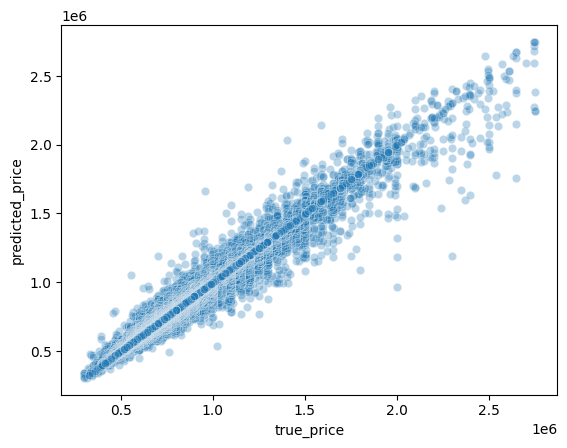

In [21]:
sns.scatterplot(flats_analysis_df, x='true_price', y='predicted_price', alpha=0.3)
plt.show()

In [22]:
filename = "../data/invalid_properties_indexes.txt"

loaded_index = []

with open(filename, "r") as f:
    for line in f:
        loaded_index.append(int(line.strip()))

invalid_properties_indexes = pd.Index(loaded_index)

In [23]:
flats_analysis_df['invalid_property'] = flats_analysis_df.index.isin(invalid_properties_indexes)



In [24]:
pd.pivot_table(flats_analysis_df, values='abs_residual', index='building_type', columns='error_category', aggfunc='count')

error_category,high_error,low_error,medium_error
building_type,,,
apartment,42,1802,23
block,26,4667,32
other,15,1731,19
tenement,11,943,19


In [32]:
pd.set_option('display.float_format', '{:.2f}'.format)


def calculate_mape(y_true, y_pred):
    # Avoid division by zero for true_price of 0
    return np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


print("\nMetrics for the entire dataset:")
overall_metrics = pd.Series({
    'count': len(flats_analysis_df),
    'avg_price': flats_analysis_df['true_price'].mean(),
    'MAPE': calculate_mape(flats_analysis_df['true_price'], flats_analysis_df['predicted_price']),
    'RMSE': calculate_rmse(flats_analysis_df['true_price'], flats_analysis_df['predicted_price'])
})

display(overall_metrics)

for col in ['invalid_property', 'error_category', 'error_category_pct', 'district', 'neighborhood',  'building_type', 'is_private_owner', 'rooms_number', 'construction_status']:
    col_metrics = flats_analysis_df.groupby(col).apply(lambda x: pd.Series({
        'count': int(len(x)),
        'avg_price': x['true_price'].mean(),
        'MAPE': calculate_mape(x['true_price'], x['predicted_price']),
        'RMSE': calculate_rmse(x['true_price'], x['predicted_price'])
    }))
    display(col_metrics)


min_area = raw_df['area_m2'].min()
max_area = raw_df['area_m2'].max()


area_bins = [0, 50, 70, 100, max_area + 1] 
area_labels = ['<50m2', '50-70m2', '70-100m2', '100+m2']

residuals_with_area = residuals_df.merge(
    raw_df[['area_m2']],
    left_index=True,
    right_index=True
)

residuals_with_area['area_bucket'] = pd.cut(
    residuals_with_area['area_m2'],
    bins=area_bins,
    labels=area_labels,
    right=False
)


area_bucket_metrics = residuals_with_area.groupby('area_bucket').apply(lambda x: pd.Series({
    'count': len(x),
    'MAPE': calculate_mape(x['true_price'], x['predicted_price']),
    'RMSE': calculate_rmse(x['true_price'], x['predicted_price'])
}))

print("\nMetrics by Area Bucket:")
display(area_bucket_metrics)


max_age = raw_df['building_age'].max()

age_bins = [0, 5, 10, 20, 50, 75, max_age + 1]
age_labels = ['0-5 years', '6-10 years', '11-20 years', '21-50 years', '50-75 years', '75+ years']

residuals_with_age = residuals_df.merge(
    raw_df[['building_age']],
    left_index=True,
    right_index=True
)


residuals_with_age['building_age_bucket'] = pd.cut(
    residuals_with_age['building_age'],
    bins=age_bins,
    labels=age_labels,
    right=False 
)

age_bucket_metrics = residuals_with_age.groupby('building_age_bucket').apply(lambda x: pd.Series({
    'count': len(x),
    'MAPE': calculate_mape(x['true_price'], x['predicted_price']),
    'RMSE': calculate_rmse(x['true_price'], x['predicted_price'])
}))

print("\nMetrics by Building Age Bucket:")
display(age_bucket_metrics)



Metrics for the entire dataset:


count         9330.00
avg_price   931190.87
MAPE             5.33
RMSE         88525.66
dtype: float64

,count,avg_price,MAPE,RMSE
invalid_property,,,,
False,9330.00,931190.87,5.33,88525.66


,count,avg_price,MAPE,RMSE
error_category,,,,
high_error,94.00,1810411.01,29.24,500253.26
low_error,9143.00,916666.03,4.90,66866.55
medium_error,93.00,1470480.74,23.82,306100.40


,count,avg_price,MAPE,RMSE
error_category_pct,,,,
high_error,1535.00,1000357.34,16.38,196831.57
low_error,5834.00,912505.35,1.82,22904.17
medium_error,1961.00,932639.53,7.14,73475.50


,count,avg_price,MAPE,RMSE
district,,,,
bemowo,513.00,941766.01,5.26,77138.04
bialoleka,877.00,714262.17,4.38,63391.69
bielany,498.00,830186.85,5.00,78535.77
mokotow,1502.00,1059285.61,5.38,100744.13
ochota,390.00,896375.57,5.87,85415.67
praga_polnoc,410.00,881195.07,4.01,64636.53
praga_poludnie,792.00,880916.48,5.71,86070.79
rembertow,106.00,610696.05,3.93,46957.47
srodmiescie,616.00,1176370.91,6.77,122573.35


,count,avg_price,MAPE,RMSE
neighborhood,,,,
aleksandrow,1.00,1215000.00,1.01,12222.81
anin,11.00,962863.64,4.92,83637.17
augustowka,26.00,1033677.88,5.34,109202.36
bemowo_lotnisko,92.00,854887.47,5.85,80665.33
bialoleka_dworska,44.00,772537.64,6.35,143512.24
...,...,...,...,...
zaluski,1.00,450000.00,7.76,34925.21
zawady,45.00,1168075.00,5.99,86925.75
zeran,82.00,767041.96,5.54,75114.09


,count,avg_price,MAPE,RMSE
building_type,,,,
apartment,1867.00,1130124.36,5.65,110197.18
block,4725.00,829469.62,5.32,75835.51
other,1765.00,942375.69,4.56,85538.91
tenement,973.00,1023156.83,6.19,103174.57


,count,avg_price,MAPE,RMSE
is_private_owner,,,,
0,7748.00,931301.99,4.95,83285.90
1,1582.00,930646.66,7.21,110660.99


,count,avg_price,MAPE,RMSE
rooms_number,,,,
1,1066.00,569941.21,5.29,47391.74
2,4149.00,815113.11,5.34,73802.45
3,3271.00,1086860.46,5.40,106264.33
4,789.00,1357235.66,4.97,115687.92
more,55.00,1319449.76,6.93,106860.48


,count,avg_price,MAPE,RMSE
construction_status,,,,
missing_value,1496.00,903779.13,5.72,89187.77
ready_to_use,4841.00,978039.06,6.00,101095.85
to_completion,2144.00,900166.26,3.29,56850.96
to_renovation,849.00,790711.07,6.00,75278.12



Metrics by Area Bucket:


,count,MAPE,RMSE
area_bucket,,,
<50m2,4710.00,5.09,57994.74
50-70m2,3190.00,5.35,90117.71
70-100m2,1330.00,6.16,149037.02
100+m2,100.00,5.23,135168.98



Metrics by Building Age Bucket:


,count,MAPE,RMSE
building_age_bucket,,,
0-5 years,2033.00,3.75,69059.01
6-10 years,797.00,6.04,107984.62
11-20 years,1068.00,6.25,119576.45
21-50 years,1538.00,5.77,87038.63
50-75 years,1946.00,5.93,71228.59
75+ years,617.00,5.84,105958.82


In [26]:
# Get top N features based on mean absolute SHAP values
mean_abs_shap = np.abs(shap_values_test).mean(0)


feature_importance_df = pd.DataFrame({
    'feature_name': X_test_selected_final.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

top_N = 40
top_N_features = feature_importance_df.head(top_N)

print(f"Top {top_N} Features Based on Mean Absolute SHAP Values:")
print("=" * 60)
for i, (idx, row) in enumerate(top_N_features.iterrows(), 1):
    print(f"{i:2d}. {row['feature_name']:<40} {row['mean_abs_shap']:.6f}")

print(f"\nTotal features in model: {len(feature_importance_df)}")
print(f"Top {top_N} features account for {top_N_features['mean_abs_shap'].sum() / feature_importance_df['mean_abs_shap'].sum() * 100:.1f}% of total SHAP importance")

# You can also get just the list of feature names
top_N_feature_names = top_N_features['feature_name'].tolist()
print(f"\nTop {top_N} feature names as a list:")
print(top_N_feature_names)


Top 40 Features Based on Mean Absolute SHAP Values:
 1. area_m2                                  0.152267
 2. distance_to_center_km                    0.076056
 3. rooms_number_original                    0.067156
 4. building_age                             0.046084
 5. room_size_m2                             0.044975
 6. latitude                                 0.030102
 7. construction_status_ready_to_use         0.018530
 8. longitude                                0.015074
 9. has_dishwasher                           0.011382
10. rooms_number_2                           0.009907
11. building_type_block                      0.008884
12. construction_status_to_renovation        0.008241
13. rooms_number_1                           0.007775
14. has_lift                                 0.007275
15. has_separate_kitchen                     0.007023
16. district_srodmiescie                     0.006482
17. building_floors_num                      0.005659
18. district_bialoleka        

### SHAP Force Plots for High-Residual Instances

These plots show feature contributions for individual predictions. Red features increase the prediction, blue features decrease it.

2025-06-12 01:44:12,834 - INFO - 
--- Analyzing instance ID: 65979253 (index in X_test_selected_final: 1673) ---
2025-06-12 01:44:12,836 - INFO - True Price: 2300000.00, Predicted Price: 1190272.67, Residual: 1109727.33


SHAP Force Plot for instance ID: 65979253

SHAP Waterfall Plot for instance ID: 65979253


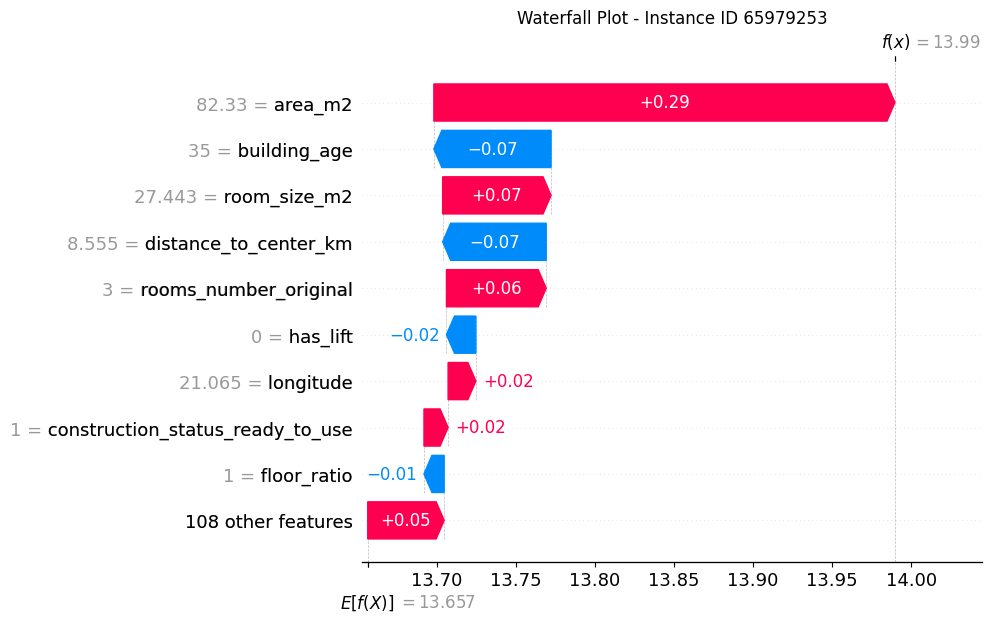

2025-06-12 01:44:13,247 - INFO - 
--- Analyzing instance ID: 65903147 (index in X_test_selected_final: 6868) ---
2025-06-12 01:44:13,248 - INFO - True Price: 2000000.00, Predicted Price: 967161.89, Residual: 1032838.11


SHAP Force Plot for instance ID: 65903147

SHAP Waterfall Plot for instance ID: 65903147


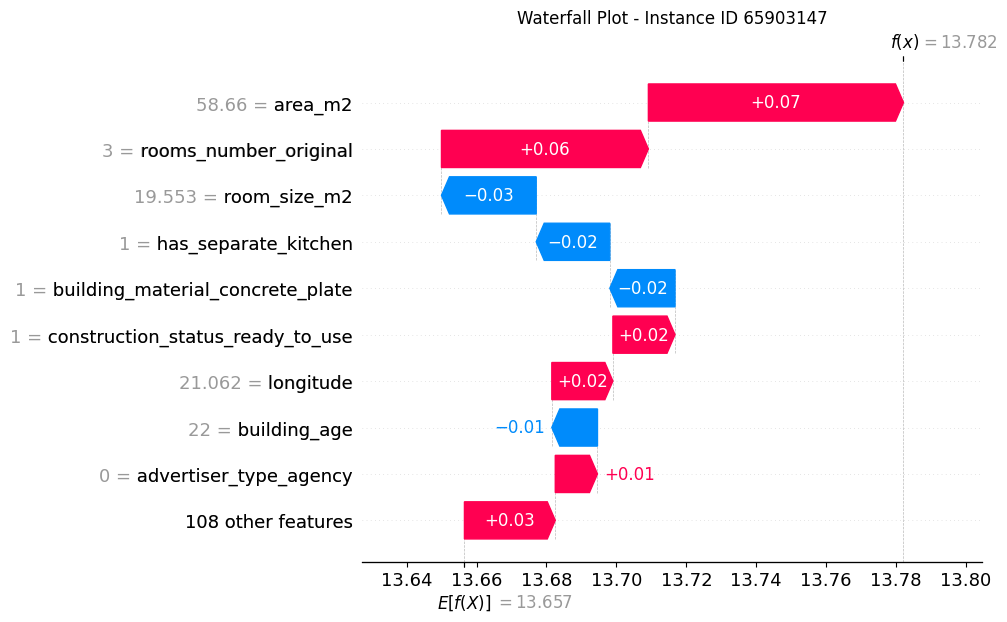

2025-06-12 01:44:13,503 - INFO - 
--- Analyzing instance ID: 64921655 (index in X_test_selected_final: 2748) ---
2025-06-12 01:44:13,503 - INFO - True Price: 2650000.00, Predicted Price: 1759359.89, Residual: 890640.11


SHAP Force Plot for instance ID: 64921655

SHAP Waterfall Plot for instance ID: 64921655


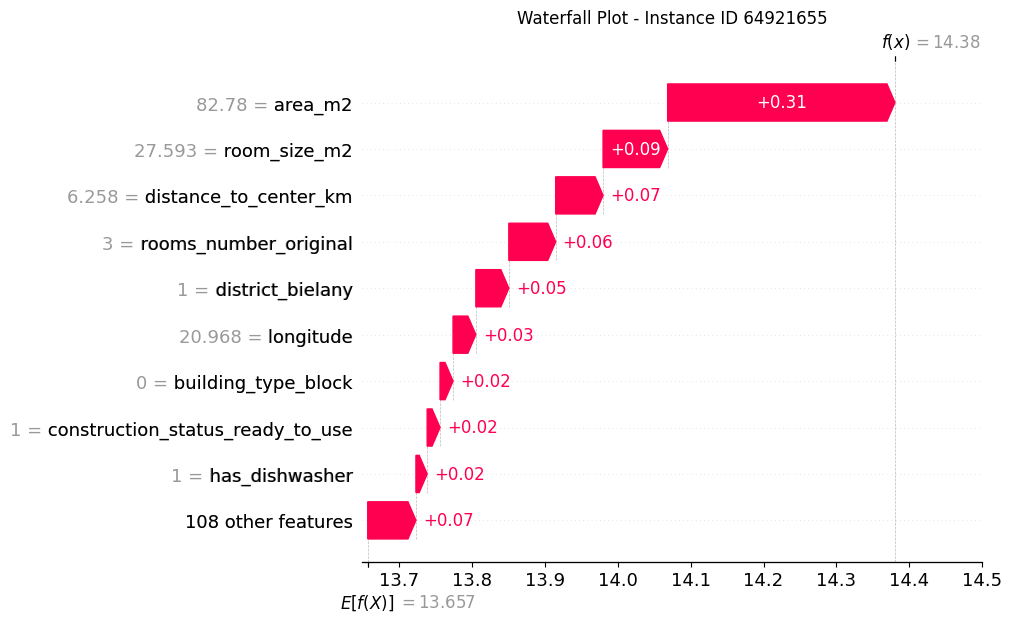

In [27]:

num_outliers_to_analyze = 3
top_outlier_indices = residuals_df.head(num_outliers_to_analyze).index

shap_expected_value = explainer.expected_value
if isinstance(shap_expected_value, list):
    shap_expected_value = shap_expected_value[0]


for instance_id in top_outlier_indices:
    try:
        instance_idx_in_shap_array = X_test_selected_final.index.get_loc(instance_id)
        logging.info(f"\n--- Analyzing instance ID: {instance_id} (index in X_test_selected_final: {instance_idx_in_shap_array}) ---")
        logging.info(f"True Price: {residuals_df.loc[instance_id, 'true_price']:.2f}, Predicted Price: {residuals_df.loc[instance_id, 'predicted_price']:.2f}, Residual: {residuals_df.loc[instance_id, 'residual']:.2f}")

        print(f"SHAP Force Plot for instance ID: {instance_id}")
        shap.force_plot(
            shap_expected_value,
            shap_values_test[instance_idx_in_shap_array, :],
            X_test_selected_final.iloc[instance_idx_in_shap_array, :],
            matplotlib=False 
        )


        print(f"\nSHAP Waterfall Plot for instance ID: {instance_id}")

        waterfall_explanation = shap.Explanation(
            values=shap_values_test[instance_idx_in_shap_array,:],
            base_values=shap_expected_value,
            data=X_test_selected_final.iloc[instance_idx_in_shap_array,:].values, 
            feature_names=X_test_selected_final.columns.tolist()
        )
        shap.waterfall_plot(waterfall_explanation, show=False) 
        plt.title(f"Waterfall Plot - Instance ID {instance_id}")
        plt.show()

    except KeyError:
        logging.warning(f"Instance ID {instance_id} from residuals_df not found in X_test_selected_final.index. Skipping.")
    except Exception as e:
        logging.error(f"Error generating SHAP plots for instance ID {instance_id}: {e}")

--- 
## 7. Counterfactual Analysis

Let's take one of the high-residual instances and see how changing its most influential features (according to SHAP) might alter the prediction. This is a manual approach.

**Note**: This is a simplified exploration. True counterfactual generation often requires optimization algorithms (e.g., finding the *minimal* change to achieve a target prediction) and specialized libraries like DiCE.

In [28]:
%ls

download_geodata.py                model_base.ipynb
feature_comparison_analysis.ipynb  model_base_poi_pano.ipynb
feature_comparison_matrix.csv      optuna_studies/
feature_sets_summary.csv           residuals_high.csv
hyperparameter_optuna.ipynb        shap_values/
mlruns/                            summary.ipynb
model.ipynb


In [29]:
residuals_df[residuals_df['abs_residual']/residuals_df['true_price'] >0.06].to_csv("residuals_high.csv", index=True)

In [44]:
import pandas as pd
import numpy as np
import logging


N_INSTANCES_TO_ANALYZE = 20

N_FEATURES_TO_TEST = 5


try:
    if 'abs_residual' in residuals_df.columns:
        top_outlier_indices = residuals_df.nlargest(N_INSTANCES_TO_ANALYZE, 'abs_residual').index
    else:
        residuals_df['residual_abs'] = residuals_df['residual'].abs()
        top_outlier_indices = residuals_df.nlargest(N_INSTANCES_TO_ANALYZE, 'residual_abs').index
        logging.warning("Column 'abs_residual' not found. Used 'residual_abs' instead.")
except Exception as e:
    logging.error(f"Could not identify top outliers from residuals_df: {e}")

    top_outlier_indices = pd.Index([])



all_top_results = []

logging.info(f"Counterfactual Analysis for Top {N_INSTANCES_TO_ANALYZE} Outliers")
logging.info("="*50)


for instance_id in top_outlier_indices:
    try:
        instance_idx_in_shap = X_test_selected_final.index.get_loc(instance_id)
    except KeyError:
        logging.warning(f"Instance ID {instance_id} not found in the test set's SHAP values. Skipping.")
        continue

    original_features = X_test_selected_final.iloc[instance_idx_in_shap, :].copy()
    instance_shap_values = shap_values_test[instance_idx_in_shap, :]
    true_price = residuals_df.loc[instance_id, 'true_price']

    # Get the original prediction
    if 'sklearn_pipeline_model' in locals() and (MODEL_NAME_FOR_ANALYSIS not in ["LightGBM", "XGBoost", "XGBoostQuantile"] or not hasattr(actual_model, 'predict')):
        original_prediction_log = sklearn_pipeline_model.predict(original_features.to_frame().T)[0]
    else:
        original_prediction_log = actual_model.predict(original_features.to_frame().T)[0]
    original_prediction = np.exp(original_prediction_log)
    original_error = original_prediction - true_price

    feature_importances = pd.Series(np.abs(instance_shap_values), index=X_test_selected_final.columns)
    top_features = feature_importances.nlargest(N_FEATURES_TO_TEST).index.tolist()

    logging.info(f"Analyzing Instance ID: {instance_id} | Original Prediction: {original_prediction:,.0f} | True Price: {true_price:,.0f} | Error: {original_error:,.0f}")


    instance_results = []

    for feature in top_features:
        original_value = original_features[feature]

        modification_points = {}
        is_boolean = (
            feature.startswith(('has_', 'construction_status_', 'building_type_')) or
            set(X_test_selected_final[feature].unique()) <= {0, 1}
        )
        if is_boolean:
            mod_value = 1 - original_value
            modification_points[f"flip_to_{int(mod_value)}"] = mod_value


        elif feature in ['area_m2', 'room_size_m2', 'floor_ratio'] or feature.startswith(('pca', 'distance_', 'dist_', 'count_')):
            modification_points = {
                "-25%": original_value * 0.75,
                "-10%": original_value * 0.90,
                "*-1": original_value * -1,
                "+10%": original_value * 1.10,
                "+25%": original_value * 1.25,
            }
        elif feature in ['building_age',]:
            modification_points = {
                "-25%": original_value * 0.75,
                "-50%": original_value * 0.50,
                "*-1": original_value * -1,
                "+50%": original_value * 1.50,
                "+25%": original_value * 1.25,
            }
                # 1. Skip 'pano_' features
        elif feature.startswith('pano_'):
            modification_points = {
                "-50%": original_value * 0.50,
                "*-1": original_value * -1,
                "+50%": original_value * 1.50,
            }

        else:

            continue


        for mod_name, mod_value in modification_points.items():
            if np.isclose(mod_value, original_value):
                continue

            counterfactual_features = original_features.copy()
            counterfactual_features[feature] = mod_value

            if 'sklearn_pipeline_model' in locals() and (MODEL_NAME_FOR_ANALYSIS not in ["LightGBM", "XGBoost", "XGBoostQuantile"] or not hasattr(actual_model, 'predict')):
                cf_prediction_log = sklearn_pipeline_model.predict(counterfactual_features.to_frame().T)[0]
            else:
                cf_prediction_log = actual_model.predict(counterfactual_features.to_frame().T)[0]
            
            cf_prediction = np.exp(cf_prediction_log)
            new_error = cf_prediction - true_price
            error_reduction = abs(original_error) - abs(new_error)
            
            if error_reduction>5000:
                instance_results.append({
                    "instance_id": instance_id,
                    "feature": feature,
                    "modification": mod_name,
                    "original_prediction": original_prediction,
                    "cf_prediction": cf_prediction,
                    "true_price": true_price,
                    "error_reduction": error_reduction
                })
    

    if instance_results:
        instance_df = pd.DataFrame(instance_results)
        top_5_for_instance = instance_df.nlargest(5, 'error_reduction')
        all_top_results.append(top_5_for_instance)



if all_top_results:
    final_results_df = pd.concat(all_top_results)

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.float_format', '{:,.2f}'.format)

    print("\nCounterfactual Analysis Summary")
    print("="*50)
    print("Top 5 changes per instance that reduced prediction error the most:")
    
    final_results_df.set_index('instance_id', inplace=True)
    display(final_results_df)

else:
    logging.warning("No counterfactual results were generated.")

2025-06-12 02:06:31,746 - INFO - Counterfactual Analysis for Top 20 Outliers
2025-06-12 02:06:31,747 - INFO - ==================================================
2025-06-12 02:06:31,778 - INFO - Analyzing Instance ID: 65979253 | Original Prediction: 1,190,273 | True Price: 2,300,000 | Error: -1,109,727
2025-06-12 02:06:31,910 - INFO - Analyzing Instance ID: 65903147 | Original Prediction: 967,162 | True Price: 2,000,000 | Error: -1,032,838
2025-06-12 02:06:31,963 - INFO - Analyzing Instance ID: 64921655 | Original Prediction: 1,759,360 | True Price: 2,650,000 | Error: -890,640
2025-06-12 02:06:32,037 - INFO - Analyzing Instance ID: 65906372 | Original Prediction: 1,180,180 | True Price: 2,000,000 | Error: -819,820
2025-06-12 02:06:32,099 - INFO - Analyzing Instance ID: 65659145 | Original Prediction: 1,597,327 | True Price: 2,370,000 | Error: -772,673
2025-06-12 02:06:32,163 - INFO - Analyzing Instance ID: 65725684 | Original Prediction: 1,637,697 | True Price: 2,400,000 | Error: -762,3


Counterfactual Analysis Summary
Top 5 changes per instance that reduced prediction error the most:


,feature,modification,original_prediction,cf_prediction,true_price,error_reduction
instance_id,,,,,,
65979253,distance_to_center_km,*-1,"1,190,272.67","1,607,999.75","2,300,000.00","417,727.09"
65979253,area_m2,+25%,"1,190,272.67","1,469,539.06","2,300,000.00","279,266.39"
65979253,building_age,*-1,"1,190,272.67","1,452,025.90","2,300,000.00","261,753.23"
65979253,distance_to_center_km,-25%,"1,190,272.67","1,391,330.05","2,300,000.00","201,057.39"
65979253,building_age,-50%,"1,190,272.67","1,338,375.98","2,300,000.00","148,103.32"
65903147,area_m2,+25%,"967,161.89","1,177,314.81","2,000,000.00","210,152.92"
65903147,room_size_m2,+25%,"967,161.89","1,106,745.48","2,000,000.00","139,583.59"
65903147,area_m2,+10%,"967,161.89","1,055,106.88","2,000,000.00","87,944.99"
65903147,has_separate_kitchen,flip_to_0,"967,161.89","1,008,595.62","2,000,000.00","41,433.73"


--- 
## 8. Hyperparameter Quality Analysis (Using Optuna Visualizations)

This section uses Optuna's visualization tools to inspect the hyperparameter tuning process for the analyzed model. The study data is loaded from the `tuning.db` SQLite file generated by `train.py`.

In [37]:
optuna_dir = config_values.get("optuna_dir", "optuna_db_studies")
db_file = "tuning.db"
STUDY_DB_PATH = f"sqlite:///{os.path.join("..", optuna_dir, db_file)}"
#STUDY_DB_PATH = config_values['optuna']['study_db_path']

print(STUDY_DB_PATH)

optuna_study_name = f"{MODEL_NAME_FOR_ANALYSIS}_{SELECTED_FEATURES_FILENAME_FOR_ANALYSIS}_mape_v1_study"

logging.info(f"Loading Optuna study: '{optuna_study_name}' from storage: '{STUDY_DB_PATH}'")


loaded_study = optuna.load_study(study_name=optuna_study_name, storage=STUDY_DB_PATH)
logging.info(f"Successfully loaded study '{optuna_study_name}' with {len(loaded_study.trials)} trials.")
logging.info(f"Best value ({loaded_study.direction.name} for {loaded_study.best_trial.user_attrs.get('MLFLOW_CALLBACK_METRIC_NAME', 'objective value')}): {loaded_study.best_value:.6f}")
logging.info(f"Best hyperparameters: {loaded_study.best_params}")


2025-06-12 01:49:39,287 - INFO - Loading Optuna study: 'LightGBM_rfecv_base_nfeat_117_nonpca_count_loc_mape_v1_study' from storage: 'sqlite:///../optuna_studies/tuning.db'


sqlite:///../optuna_studies/tuning.db


2025-06-12 01:49:39,567 - INFO - Successfully loaded study 'LightGBM_rfecv_base_nfeat_117_nonpca_count_loc_mape_v1_study' with 100 trials.
2025-06-12 01:49:39,607 - INFO - Best value (MINIMIZE for objective value): 0.055875
2025-06-12 01:49:39,625 - INFO - Best hyperparameters: {'model__objective': 'huber', 'model__learning_rate': 0.047992188690024265, 'model__n_estimators': 2200, 'model__num_leaves': 197, 'model__max_depth': 18, 'model__min_child_samples': 5, 'model__subsample': 0.6663505333857027, 'model__colsample_bytree': 0.617185645471779, 'model__reg_alpha': 0.02698795457381878, 'model__reg_lambda': 0.15918838844879027}


### Optuna Optimization History

In [38]:
if loaded_study:
    try:
        fig_hist = optuna.visualization.plot_optimization_history(loaded_study)
        fig_hist.update_layout(title_text=f"Optimization History - {MODEL_NAME_FOR_ANALYSIS} ({SELECTED_FEATURES_FILENAME_FOR_ANALYSIS})", title_x=0.5)
        fig_hist.show()
    except Exception as e:
        logging.error(f"Could not plot optimization history: {e}")
else:
    logging.warning("Optuna study not loaded. Skipping optimization history plot.")

### Hyperparameter Importances

In [39]:
import logging


logging.getLogger('optuna').setLevel(logging.ERROR)

if loaded_study:
    try:
        fig_importance = optuna.visualization.plot_param_importances(loaded_study)
        fig_importance.update_layout(title_text=f"Hyperparameter Importances - {MODEL_NAME_FOR_ANALYSIS} ({SELECTED_FEATURES_FILENAME_FOR_ANALYSIS})", title_x=0.5)
        fig_importance.show()
    except Exception as e:
        logging.error(f"Could not plot hyperparameter importances: {e}")
else:
    logging.warning("Optuna study not loaded. Skipping hyperparameter importance plot.")

### Parallel Coordinate Plot
Helps visualize relationships between parameters and objective value.

In [40]:
if loaded_study:
    try:
        fig_parallel = optuna.visualization.plot_parallel_coordinate(loaded_study)
        fig_parallel.update_layout(title_text=f"Parallel Coordinate Plot - {MODEL_NAME_FOR_ANALYSIS} ({SELECTED_FEATURES_FILENAME_FOR_ANALYSIS})", title_x=0.5)
        fig_parallel.show()
    except Exception as e:
        logging.error(f"Could not plot parallel coordinate plot: {e}")
else:
    logging.warning("Optuna study not loaded. Skipping parallel coordinate plot.")

### Slice Plot
Shows how individual hyperparameters affect the objective value.

In [ ]:
if loaded_study:
    try:
        fig_slice = optuna.visualization.plot_slice(loaded_study) 
        fig_slice.update_layout(title_text=f"Slice Plot - {MODEL_NAME_FOR_ANALYSIS} ({SELECTED_FEATURES_FILENAME_FOR_ANALYSIS})", title_x=0.5)
        fig_slice.show()
    except Exception as e:
        logging.error(f"Could not plot slice plot: {e}")
else:
    logging.warning("Optuna study not loaded. Skipping slice plot.")